http://archive.ics.uci.edu/ml/datasets/thyroid+disease [[Page](https://www.openml.org/d/57)] [[CSV](https://www.openml.org/data/get_csv/57/dataset_57_hypothyroid.arff)]
Target – Class

Scoring (10 max):
* EDA: exploration of variables and properties of data with conclusions - 1
* Data preprocessing if needed - 2
    * Handling missing values
    * Dropping unimportant features
    * Data normalization
    * Categorical encoding
* [Scikit pipeline](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) usage – 2
* Metrics and cross-validation chosen as well as reasoning behind – 1
* Different techniques for handling imbalance data (over\under sampling, class weight) - 2
* Feature engineering e.g. [transformations](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer) (nonlinear) - 1
* Feature importance and [hyperparameters](http://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers) tuning – 1

Models: Logistic Regression w\wo regularization; K-nearest neighbors

***

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Заглянем в файл, увидим, что missing values кодируются символом вопроса "?", boolean features кодируются символами "f", "t"

In [2]:
df = pd.read_csv('dataset_57_hypothyroid.csv', na_values='?', true_values='t', false_values='f')
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,False,False,False,False,False,False,False,False,...,True,125.0,True,1.14,True,109.0,False,NaN,SVHC,negative
1,23.0,F,False,False,False,False,False,False,False,False,...,True,102.0,False,NaN,False,NaN,False,NaN,other,negative
2,46.0,M,False,False,False,False,False,False,False,False,...,True,109.0,True,0.91,True,120.0,False,NaN,other,negative
3,70.0,F,True,False,False,False,False,False,False,False,...,True,175.0,False,NaN,False,NaN,False,NaN,other,negative
4,70.0,F,False,False,False,False,False,False,False,False,...,True,61.0,True,0.87,True,70.0,False,NaN,SVI,negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
age                          3771 non-null float64
sex                          3622 non-null object
on_thyroxine                 3772 non-null bool
query_on_thyroxine           3772 non-null bool
on_antithyroid_medication    3772 non-null bool
sick                         3772 non-null bool
pregnant                     3772 non-null bool
thyroid_surgery              3772 non-null bool
I131_treatment               3772 non-null bool
query_hypothyroid            3772 non-null bool
query_hyperthyroid           3772 non-null bool
lithium                      3772 non-null bool
goitre                       3772 non-null bool
tumor                        3772 non-null bool
hypopituitary                3772 non-null bool
psych                        3772 non-null bool
TSH_measured                 3772 non-null bool
TSH                          3403 non-null float64
T3_measured          

In [9]:
df['Class'].value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

* 'TBG' можно сразу выкинуть, ибо столбец пустой
* 20 boolean featuers, 6 (без 'TBG') числовых, 3 строковых
* есть missing values, их может быть и немного, но это еще ни о чем хорошем не говорит
* выборка очень-очень-очень несбалансирована. в выборке 3772 объекта, а один из target-классов представлен лишь 2(!) объектами, и что с этим делать – не ясно

In [15]:
if 'TBG' in df:
    df = df.drop(columns=['TBG'])

Посмотрим на гистограммы категориальных признаков

In [6]:
cat_features = ['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'referral_source']

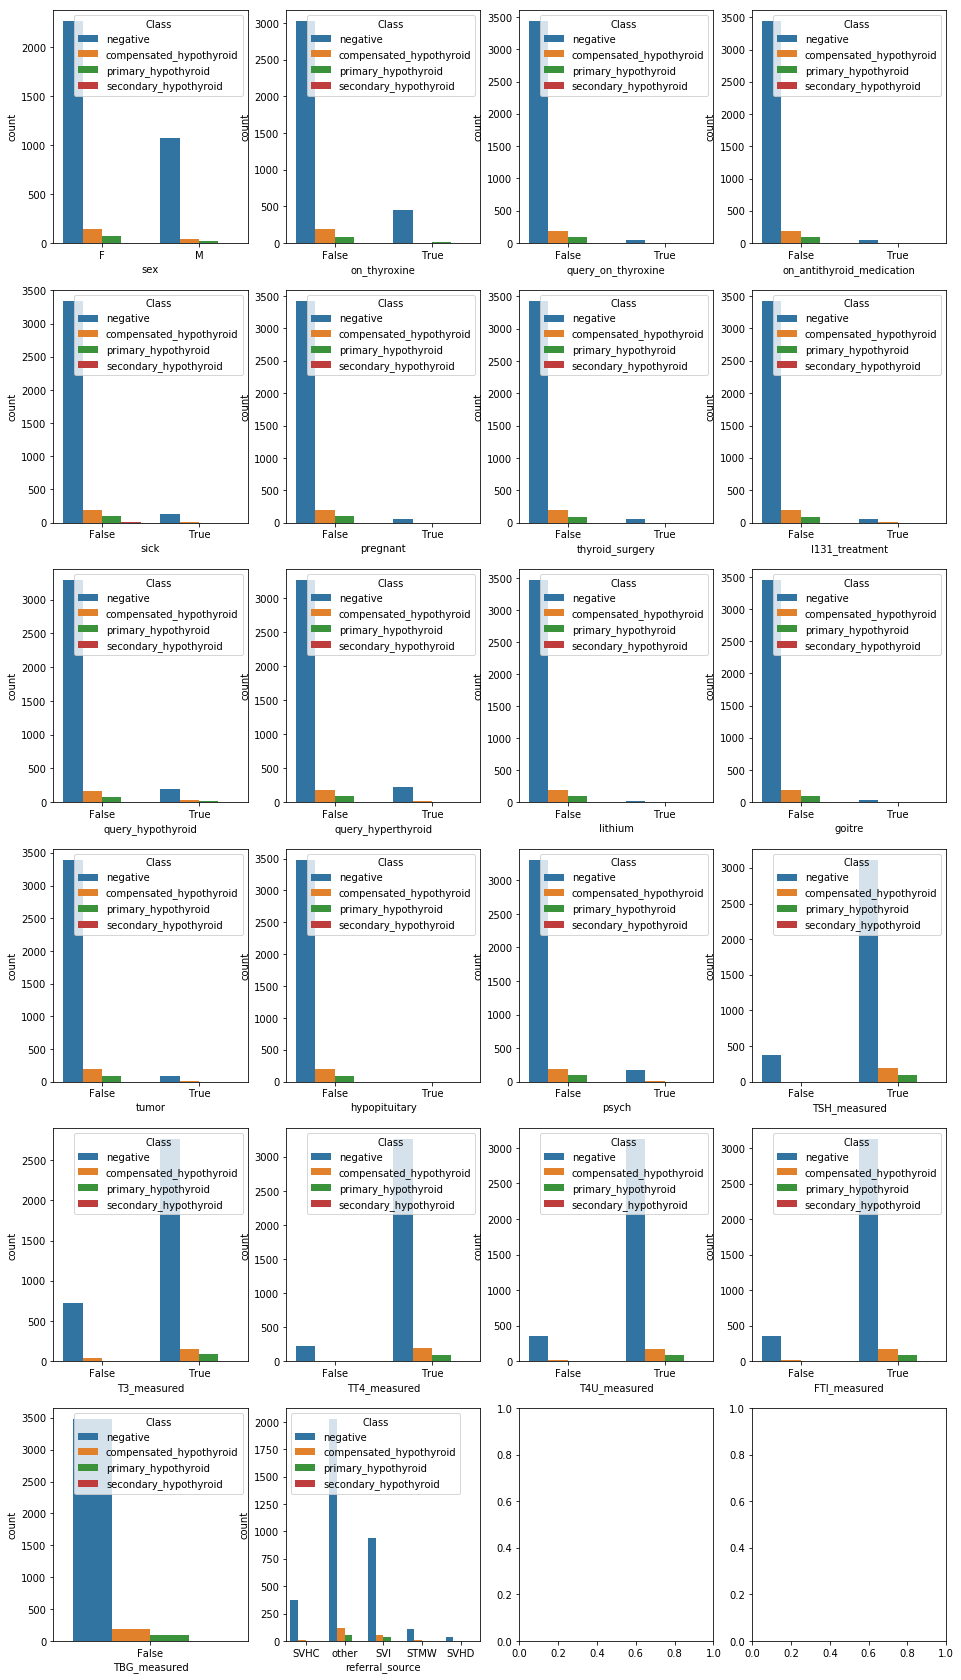

In [7]:
f, axes = plt.subplots(nrows=6, ncols=4, figsize=(16, 30))
for index, col_name in enumerate(cat_features):
    sns.countplot(x=col_name, hue='Class', data=df, ax=axes[index//4, index%4]);

* 'TBG_measured' также бесполезный признак, поскольку имеет всегда одно значение False и missing values в нем нет. поэтому выбросим его. можно, наверное, было сразу догадаться, что так будет, посмотрев на названия столбцов – если в 'TGB' ничего нет, значит этот параметр у больных не измерялся, соответственно 'TGB_**measured**' всегда должно быть False
* сказать, что по каким-то из этих признаков один из классов хорошо отделяется, я не могу
* наглядное подтверждение тому, что выборка несбалансирована

Посмотрим на гистограммы без класса Class='negative'

In [14]:
if 'TBG_measured' in df:
    df = df.drop(columns=['TBG_measured'])
cat_features = ['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'referral_source']

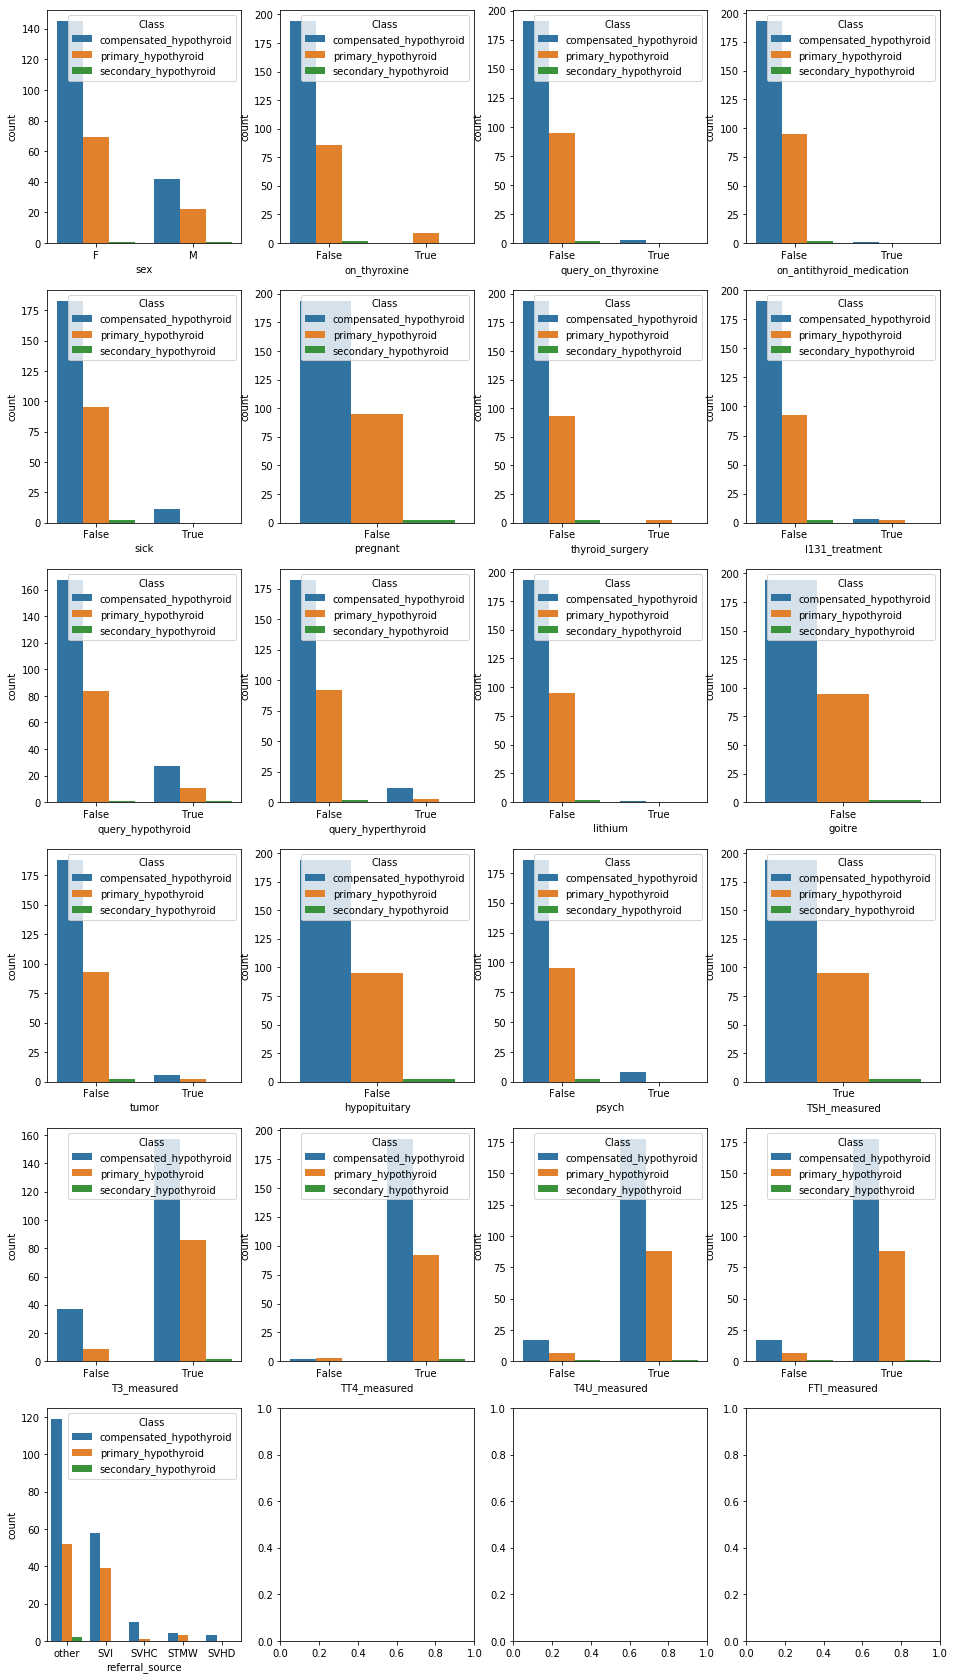

In [17]:
df0 = df[df['Class'] != 'negative']
f, axes = plt.subplots(nrows=6, ncols=4, figsize=(16, 30))
for index, col_name in enumerate(['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'referral_source']):
    sns.countplot(x=col_name, hue='Class', data=df0, ax=axes[index//4, index%4]);

* у положительных (т.е. у больных людей) трех классов некоторые признаки имеют лишь одно значение
* если смотреть на эту подвыборку отдельно, то можно отметить, что и она плохо сбалансирована
* в целом, смотря на эти графики, нельзя сказать, что в данных есть какая-нибудь очевидная структура, которая могла бы помочь в классификации

Посмотрим на распределения вещественных переменных

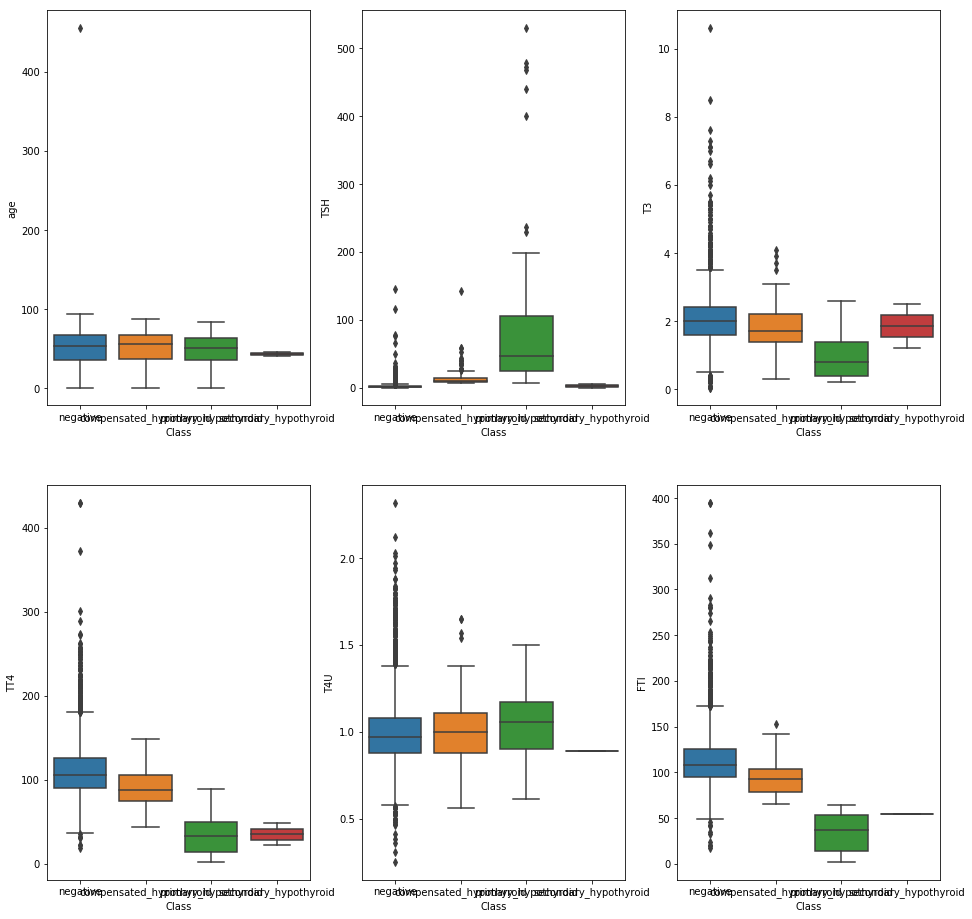

In [21]:
real_features = ['age','TSH','T3','TT4','T4U','FTI']
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 16))
for index, col_name in enumerate(real_features):
#     plt.hist(df[col_name].values)
    sns.boxplot(x='Class', y=col_name, data=df, ax=axes[index//3, index%3])

and without 'negative'

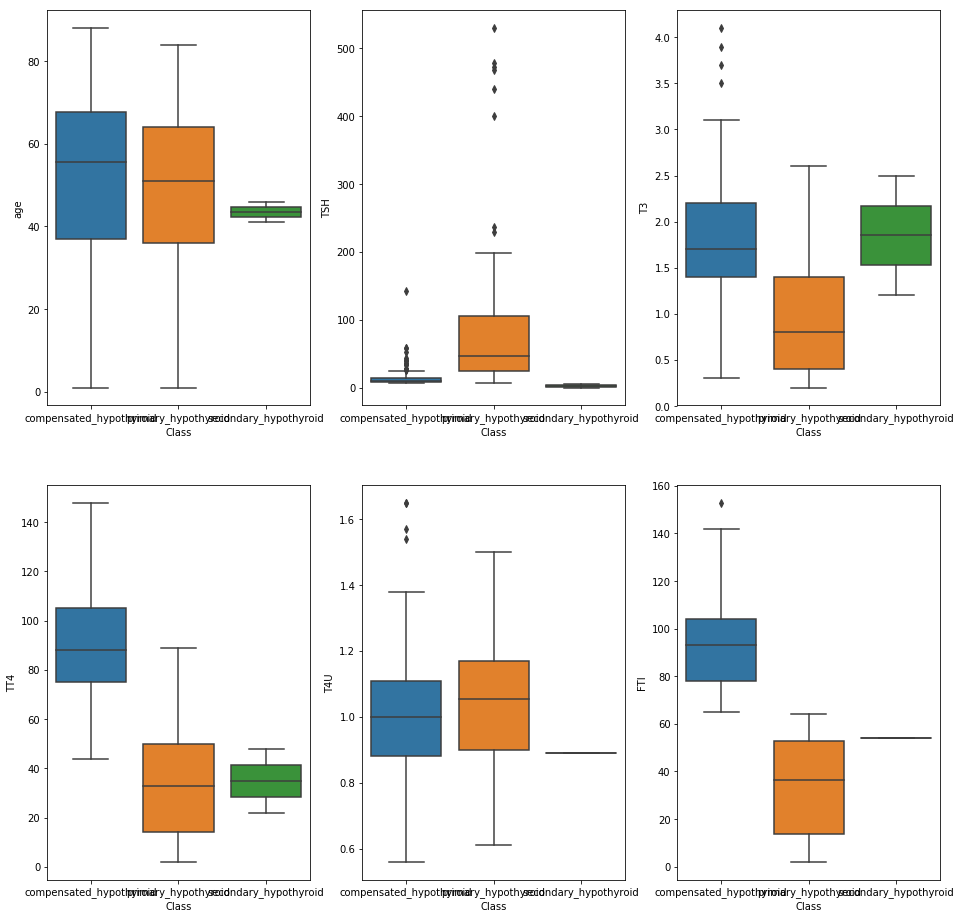

In [10]:
df0 = df[df['Class'] != 'negative']
col_names = ['age','TSH','T3','TT4','T4U','FTI']
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 16))
for index, col_name in enumerate(col_names):
    sns.boxplot(x='Class', y=col_name, data=df0, ax=axes[index//3, index%3])

* from continuous features we see that Classes may be more or less _visually_ separated
* there are some outliers (not taking 'negative' into account - it has tons)
* hypothesis: these features may probably have bigger importance than other boolean and categorical

let's for now do nothing with outliers. next, we need to decide what to do with missing values

In [31]:
df0 = df[df.isnull().any(axis=1)]

In [32]:
df0['Class'].value_counts()

negative                   1054
compensated_hypothyroid      58
primary_hypothyroid          16
secondary_hypothyroid         1
Name: Class, dtype: int64

1129 rows with at least one missing value. let's throw away all rows with Class='negative', because it probably won't hurt the model due to the heavy target classes imbalance

In [33]:
df1 = df.drop(index=df0[df0['Class'] == 'negative'].index)

In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2718 entries, 0 to 3771
Data columns (total 28 columns):
age                          2718 non-null float64
sex                          2707 non-null object
on_thyroxine                 2718 non-null bool
query_on_thyroxine           2718 non-null bool
on_antithyroid_medication    2718 non-null bool
sick                         2718 non-null bool
pregnant                     2718 non-null bool
thyroid_surgery              2718 non-null bool
I131_treatment               2718 non-null bool
query_hypothyroid            2718 non-null bool
query_hyperthyroid           2718 non-null bool
lithium                      2718 non-null bool
goitre                       2718 non-null bool
tumor                        2718 non-null bool
hypopituitary                2718 non-null bool
psych                        2718 non-null bool
TSH_measured                 2718 non-null bool
TSH                          2718 non-null float64
T3_measured          

we still have missing values in 'sex' and these rows don't belong to Class='negative'. the problem is that this feature is categorical and since i don't know the handle missing values here, i decide to throw the feature away

In [36]:
df1 = df1.drop(columns=['sex'])

let's fill missing values in what's left with median values of features for each class (all features are numeric) (median in order not be affected by outliers i decided to keep)

In [ ]:
for cls in df1['Class'].unique():
    df0 = df1[df1['Class'] == cls]
    df1.loc[df0.index] = df1.loc[df0.index].fillna(df0.median())

In [38]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2718 entries, 0 to 3771
Data columns (total 27 columns):
age                          2718 non-null float64
on_thyroxine                 2718 non-null bool
query_on_thyroxine           2718 non-null bool
on_antithyroid_medication    2718 non-null bool
sick                         2718 non-null bool
pregnant                     2718 non-null bool
thyroid_surgery              2718 non-null bool
I131_treatment               2718 non-null bool
query_hypothyroid            2718 non-null bool
query_hyperthyroid           2718 non-null bool
lithium                      2718 non-null bool
goitre                       2718 non-null bool
tumor                        2718 non-null bool
hypopituitary                2718 non-null bool
psych                        2718 non-null bool
TSH_measured                 2718 non-null bool
TSH                          2718 non-null float64
T3_measured                  2718 non-null bool
T3                     

In [39]:
df1['Class'].value_counts()

negative                   2427
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

In [45]:
df2 = df1.drop(index=df1[df1['Class'] == 'negative'].index)

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline